## Not ready yet...

# VIZBI Tutorial Session
### Part 2: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

### Lesson 4: Advanced Visualizations

by [Keiichiro Ono](http://keiono.github.io/)

----

## Outline
* Use external library for layout
* Interactive visualization with Cytoscape.js

In [11]:
import requests
import json
from IPython.display import Image
import pandas as pd
import networkx as nx
import igraph as ig
import graph_tool.all as gt
import py2cytoscape.util as cy

# Package to render networks in Cytoscape.js
from py2cytoscape import cytoscapejs as cyjs


# Basic Setup
PORT_NUMBER = 1234
IP = '137.110.137.158' # Dont' forget to update this!!!!!!!!!!!!!!!
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}

# Utulity to POST object
def create(param, dict_data):
    return requests.post(BASE + param, data=json.dumps(dict_data), headers=HEADERS)

def update(param, dict_data):
    return requests.put(BASE + param, data=json.dumps(dict_data), headers=HEADERS)
    
# Start from a clean slate!
requests.delete(BASE + 'session')

<Response [200]>

In [15]:
networks = {}
layouts = cyjs.get_layouts()

# Load local network files
yeast_network = json.load(open('data/yeast.json'))
networks['Yeast PPI Network'] = yeast_network

sf = nx.barabasi_albert_graph(100, 2)
sf_js = cy.from_networkx(sf)

# Load Visual Style file
vs_collection = json.load(open('data/style.json'))

styles = {}
for style in vs_collection:
    style_settings = style['style']
    title = style['title']
    styles[title] = style_settings

In [16]:
cyjs.render(yeast_network, styles['Directed'], 'preset')

In [20]:
cyjs.render(sf_js, styles['Directed'], 'breadthfirst')

In [18]:
# Community detection
g2 = ig.Graph.Tree(256, 2)
g2.write('tree1.graphml', format='graphml')

g2_cyjs = cy.from_igraph(g2)
create('networks', g2_cyjs)

<Response [200]>

position       (vertex)  (type: vector<double>)
_graphml_vertex_id (vertex)  (type: string)
_graphml_edge_id (edge)    (type: string)
None


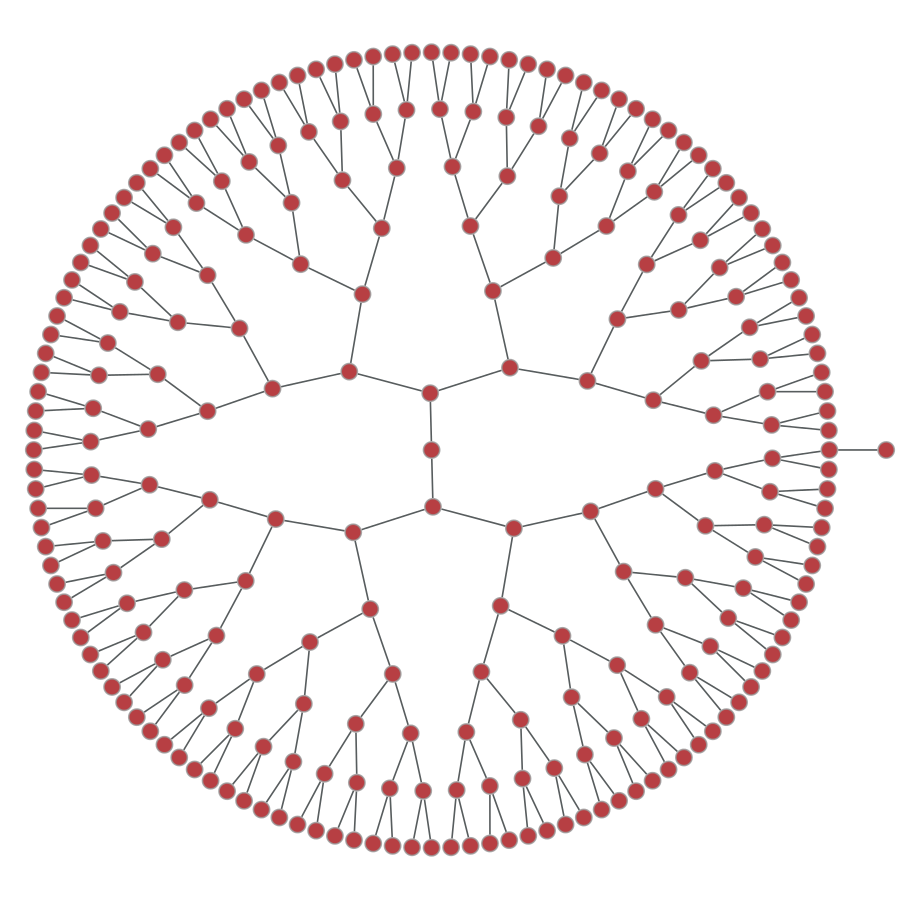

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f73d6c714a8, at 0x7f73d6c71710>

In [19]:
tree1 = gt.load_graph('tree1.graphml')
pos = gt.radial_tree_layout(tree1, tree1.vertex(0))

tree1.vertex_properties['position'] = pos
print(tree1.list_properties())
tree1.save('tree.gml')

nodes = pos.get_graph().vertices()
create('networks', g2_cyjs)


def apply_layout(pos):
    # Node X Position = size
    position_list= []
    nodes = pos.get_graph().vertices()
    
    for node in nodes:
        position = {
            'SUID': str(node),
            'view':[
                {
                    'visualProperty': 'NODE_X_LOCATION',
                    'value': pos[node][0]
                },
                {
                    'visualProperty': 'NODE_Y_LOCATION',
                    'value': pos[node][1]
                }
            ]
        }
        position_list.append(position)
    return position_list

gt.graph_draw(tree1, pos=pos, inline=True, output_size=(920,900), output="tree1.png")